In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,recall_score,f1_score,roc_auc_score,auc,roc_curve
import re as re

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
import warnings 
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline

In [2]:
train_data = pd.read_csv('../Datasets/train.csv')
test_data = pd.read_csv('../Datasets/test.csv',)
combined = [train_data,test_data]
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()
print('-' * 50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

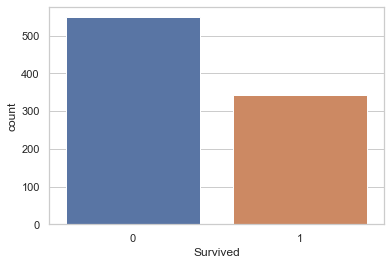

In [4]:
sns.set(style="whitegrid")
sns.countplot(train_data['Survived'],data = train_data)
plt.show()

In [5]:
print('Percentage of null values in each column of train data:\n')
(train_data.isnull().sum() / train_data.shape[0]) * 100

Percentage of null values in each column of train data:



PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [6]:
print('Percentage of null values in each column of test data:\n')
(test_data.isnull().sum() / test_data.shape[0]) * 100

Percentage of null values in each column of test data:



PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

In [7]:
train_data.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Stanley, Mr. Edward Roland",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


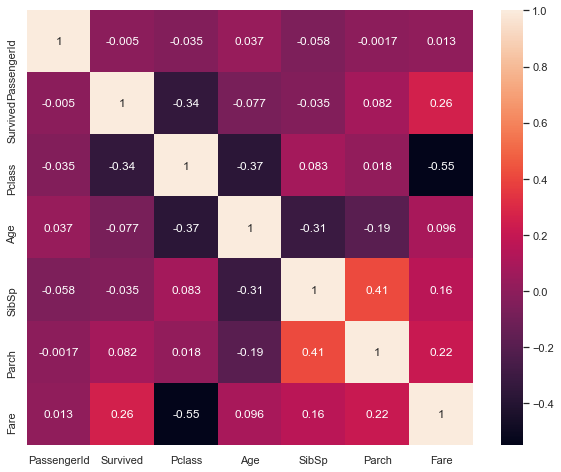

In [8]:
plt.figure(figsize = (10,8))
sns.heatmap(train_data.corr(),annot=True,cbar = True)
plt.show()

In [9]:
# dropping passengerid as it does not affect survived class
# dropping cabin as it has lots of null values 

In [10]:
train_data.drop(['PassengerId','Cabin'],inplace=True,axis = 1)
test_data.drop(['PassengerId','Cabin'],inplace=True,axis = 1)

In [11]:
train_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [12]:
train_data.loc[0,train_data.dtypes == object]

Name        Braund, Mr. Owen Harris
Sex                            male
Ticket                    A/5 21171
Embarked                          S
Name: 0, dtype: object

In [13]:
#finding correaltions between target variable and name, sex, ticket, embarked

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64


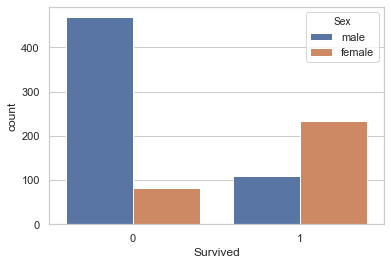

In [14]:
print(train_data.groupby(['Sex','Survived'])['Survived'].count())

sns.set(style="whitegrid")
sns.countplot(train_data['Survived'],hue = 'Sex',data = train_data)
plt.show()

In [15]:
train_data.drop(['Ticket'],axis = 1,inplace = True)
test_data.drop(['Ticket'],axis = 1,inplace = True)

Embarked  Survived
C         0            75
          1            93
Q         0            47
          1            30
S         0           427
          1           217
Name: Survived, dtype: int64


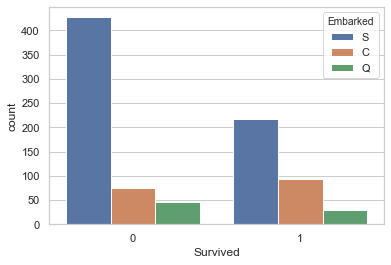

In [16]:
print(train_data.groupby(['Embarked','Survived'])['Survived'].count())
sns.set(style="whitegrid")
sns.countplot(train_data['Survived'],hue = 'Embarked',data = train_data)
plt.show()

In [17]:
#feature engineering on name, age, sibsp + parch,fare 

In [18]:
for dataset in combined:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print(pd.crosstab(train_data['Title'], train_data['Sex']))
print('-' * 50)
print(pd.crosstab(test_data['Title'], test_data['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
--------------------------------------------------
Sex     female  male
Title               
Col          0     2
Dona         1     0
Dr           0     1
Master       0    21
Miss        78     0
Mr           0   240
Mrs         72     0
Ms           1     0
Rev          0     2


In [19]:
for dataset in combined:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print(train_data[['Title', 'Survived']].groupby(['Title'], as_index = False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [20]:
for dataset in combined:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)

print (train_data[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.530973
1   (16.0, 32.0]  0.354260
2   (32.0, 48.0]  0.369048
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


In [21]:
for dataset in combined:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train_data[['FamilySize','Survived']].groupby('FamilySize',as_index = False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [22]:
for dataset in combined:
    dataset['FamilySizeCategory'] = 0
#     dataset.loc[(dataset['FamilySize']) > 4 & (dataset['FamilySize'] < 8),'FamilySizeCategory'] = 1
#     dataset.loc[dataset['FamilySize'] <= 4 , 'FamilySizeCategory'] = 2
    for i in range(len(dataset)) : 
        if(dataset.loc[i,'FamilySize'] <= 4):
            dataset.loc[i,'FamilySizeCategory'] = 2
        elif((dataset.loc[i,'FamilySize'] > 4) & (dataset.loc[i,'FamilySize'] < 8)):
            dataset.loc[i,'FamilySizeCategory'] = 1
        else:
            dataset.loc[i,'FamilySizeCategory'] = 0           
    
print (train_data[['FamilySizeCategory', 'Survived']].groupby(['FamilySizeCategory'], as_index=False).mean())
train_data['FamilySizeCategory'].nunique()

   FamilySizeCategory  Survived
0                   0  0.000000
1                   1  0.204082
2                   2  0.400483


3

In [23]:
for dataset in combined:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [24]:
for dataset in combined:
    dataset['Fare'] = dataset['Fare'].fillna(train_data['Fare'].median())
train_data['CategoricalFare'] = pd.qcut(train_data['Fare'], 4)
print (train_data[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [25]:
for dataset in combined:
    dataset['Embarked'] = dataset['Embarked'].fillna(train_data['Embarked'].mode()[0])
train_data[['Embarked','Survived']].groupby(['Embarked'],as_index = False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Survived            891 non-null    int64   
 1   Pclass              891 non-null    int64   
 2   Name                891 non-null    object  
 3   Sex                 891 non-null    object  
 4   Age                 891 non-null    int32   
 5   SibSp               891 non-null    int64   
 6   Parch               891 non-null    int64   
 7   Fare                891 non-null    float64 
 8   Embarked            891 non-null    object  
 9   Title               891 non-null    object  
 10  CategoricalAge      891 non-null    category
 11  FamilySize          891 non-null    int64   
 12  FamilySizeCategory  891 non-null    int64   
 13  IsAlone             891 non-null    int64   
 14  CategoricalFare     891 non-null    category
dtypes: category(2), float64(1), int32(1), in

In [27]:
for dataset in combined:
    dataset['Sex'] = dataset['Sex'].map( {'female' : 0,'male' : 1} )
    
    dataset.loc[dataset['Age'] <= 16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32),'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48),'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64),'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 80),'Age'] = 4

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    drop_columns = ['Name','SibSp','Parch','FamilySize']
    dataset.drop(drop_columns,axis = 1,inplace = True)

drop_col = ['CategoricalAge','CategoricalFare']
train_data.drop(drop_col,axis = 1,inplace = True)

In [28]:
train_data.FamilySizeCategory.nunique()

3

In [29]:
train_data = pd.get_dummies(train_data, prefix = ['Title'], columns = ['Title'])
test_data = pd.get_dummies(test_data, prefix = ['Title'], columns = ['Title'])

In [30]:
train_data.FamilySizeCategory.nunique()

3

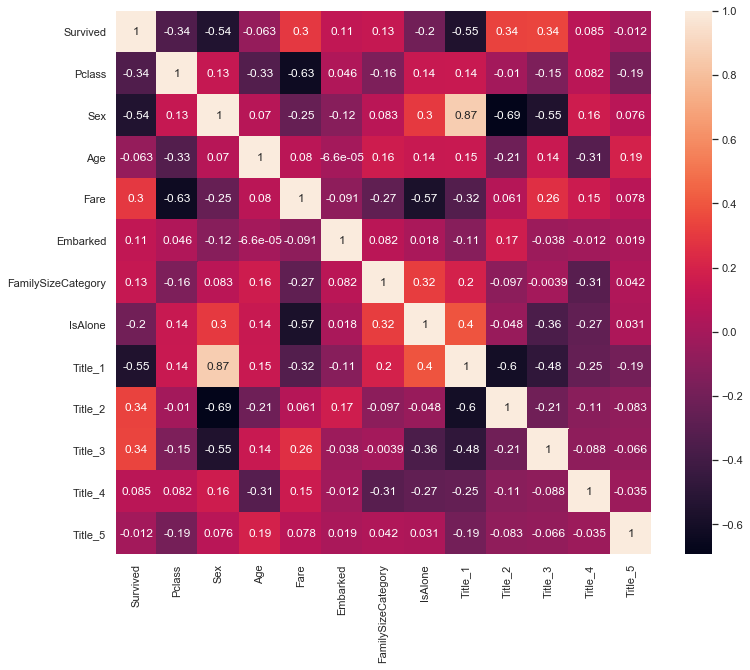

In [31]:
plt.figure(figsize = (12,10))
sns.heatmap(train_data.corr(),annot=True,cbar = True)
plt.show()

In [32]:
x_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]
x_test = test_data
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

# Classifiers Used:
## 1. Logistic Regression
## 2. Gaussian Naive Bayes
## 3. Decision Tree 
## 4. K Nearest neighbors
## 5. Multi Layer Perceptron 
## 6. perceptron
## 7. Linear SVC
## 8. SVC


In [33]:
# std_scaler = StandardScaler()
# x_train = std_scaler.fit_transform(x_train)
# x_test = std_scaler.transform(x_test)
x_train

,Pclass,Sex,Age,Fare,Embarked,FamilySizeCategory,IsAlone,Title_1,Title_2,Title_3,Title_4,Title_5
0,3,1,1,0,0,2,0,1,0,0,0,0
1,1,0,2,3,1,2,0,0,0,1,0,0
2,3,0,1,1,0,2,1,0,1,0,0,0
3,1,0,2,3,0,2,0,0,0,1,0,0
4,3,1,2,1,0,2,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,1,1,0,2,1,0,0,0,0,1
887,1,0,1,2,0,2,1,0,1,0,0,0
888,3,0,1,2,0,2,0,0,1,0,0,0
889,1,1,1,2,1,2,1,1,0,0,0,0


In [ ]:
def best_classifier_using_kfold(clf,k = 10):
    best_accuracy = 0

    kf = StratifiedKFold(n_splits = k,random_state = 42,shuffle = False)
    best_pred,best_pred_y,best_train_x = [],[],[]
    
    accuracies, precisions, f1scores, recall_scores, roc_auc_scores = [],[],[],[],[]
    for train_index,test_index in kf.split(x_train,y_train):
        
        train_x,test_x = x_train.values[train_index],x_train.values[test_index]
        train_y,test_y = y_train.values[train_index],y_train.values[test_index]
        clf.fit(train_x,train_y)
        y_pred = clf.predict(test_x)
        if(accuracy_score(y_pred,test_y) >= best_accuracy):
            best_pred = y_pred
            best_pred_y = test_y
            best_train_x = test_x
        accuracies.append(accuracy_score(y_pred,test_y))
        precisions.append(precision_score(y_pred,test_y))
        f1scores.append(f1_score(y_pred,test_y))
        recall_scores.append(recall_score(y_pred,test_y))
        roc_auc_scores.append(roc_auc_score(y_pred,test_y))
    indices = ['Mean Accuracy','Mean of Precision Scores','Mean of F1 scores','Mean of Recall score','Mean of Roc-Auc score']

    eval = pd.DataFrame([np.mean(accuracies) * 100,np.mean(precisions) * 100,np.mean(f1scores)     * 100,np.mean(recall_scores) * 100,np.mean(roc_auc_scores) * 100],columns=['Value'],index=indices)

    cm = pd.DataFrame(confusion_matrix(best_pred,best_pred_y),index = ['Survived','Not Survived'],columns = ['Survived','Not Survived'])
    eval.index.name = 'Metrics'
    
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()
    
    print(eval)
    print('cross-val-score',np.mean(cross_val_score(clf,x_train,y_train,cv = 10)) * 100)
    
    y_pred = clf.predict_proba(x_train)
    fpr,tpr,_ = roc_curve(y_train,y_pred[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.5, 1.05])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC curve')
    plt.show()


# Prediction 

In [ ]:
model1 = LogisticRegression()
best_classifier_using_kfold(model1)

In [ ]:
model2 = GaussianNB()
best_classifier_using_kfold(model2)

In [ ]:
model3 = DecisionTreeClassifier()
best_classifier_using_kfold(model3)


In [47]:
model4 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=81, p=2,
                     weights='distance')
best_classifier_using_kfold(model4)

NameError: name 'best_classifier_using_kfold' is not defined

In [ ]:
model5 = MLPClassifier()
best_classifier_using_kfold(model5)

In [ ]:
model6 = SVC(kernel = 'linear',probability=True)
best_classifier_using_kfold(model6)

In [ ]:
#hyper-pramater tuning

In [ ]:
# Param grid for Multi Layer Perceptron
model5_pg = {
    'hidden_layer_sizes': [(30,40,30), (40,40,40,40,40)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.0002, 0.0004,0.001,0.002,0.01],
    'learning_rate': ['constant','adaptive'],
}

#paramgrid for decision tree
model3_pg = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'random_state': [42]
}

# model4_pg = {
#     'n_neighbors': [3,5,7,9,13,15,20]
# }
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
model4_pg = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

model6_pg = {
     'C': [0.1, 1, 10, 100],  
     'gamma': [0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly', 'sigmoid']  ,
     'probability': [True,False]
}


In [ ]:
#using grid search and random grid search for tuning

# Grid Search Cross Validation
# gscv = GridSearchCV(model6, param_grid = model6_pg, cv = 10, verbose=False, n_jobs=-1)


# Randomized Search Cross Validation
rscv = RandomizedSearchCV(model3, param_distributions = model3_pg, n_iter = 100, cv = 10, verbose=False, random_state=42, n_jobs = -1)


In [ ]:
# gscv.fit(x_train,y_train)
# y_predict1 = gscv.best_estimator_.predict(x_test)

rscv.fit(x_train,y_train)
# y_predict2 = rscv.best_estimator_.predict(x_test)

In [ ]:
y = rscv.best_estimator_.predict(x_test)
y_pred = rscv.best_estimator_.predict_proba(x_test)
y[y == 1].size

In [ ]:
count = 0
for i in range(0,y_pred.shape[0]):
    if((y_pred[i][1] >= 0.4) & (y_pred[i][1] <= 0.6)):
        count += 1
        y[i] = 0
count

In [ ]:
# gscv_submit = pd.DataFrame(y_predict1,columns = ['Survived'],index = [i + 892 for i in range(0,418)])
rscv_submit = pd.DataFrame(y,columns = ['Survived'],index = [i + 892 for i in range(0,418)])

# gscv_submit.index.name = 'PassengerId'
rscv_submit.index.name = 'PassengerId'

In [ ]:
# gscv_submit[gscv_submit == 1].count()

In [ ]:
rscv_submit[rscv_submit == 1].count()

In [ ]:
rscv_submit


In [ ]:
# gscv_submit.to_csv('gscv_submission.csv')
rscv_submit.to_csv('rscv_submission.csv')


In [54]:
model4.fit(x_train,y_train)
yt = model4.predict(x_test)


In [55]:
tpotsub = pd.DataFrame(yt,columns = ['Survived'],index = [i + 892 for i in range(0,418)])

tpotsub.index.name = 'PassengerId'

In [59]:
tpotsub

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [56]:
tpotsub.to_csv('rscv_submission.csv')
